<center><h1>Cohort Analysis & RFM Analysis</h1></center>

<i><center>Created by Chanchit Sewaleekunanon</center></i>

___
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset that will be used in this project is 'supermarket_data.csv'. The dataset itself is from a company in the retail industry between the very beginning of 2007 to the mid of 2008. However, the main purpose of this project is come up with Cohort & RFM analyses.

___
<h4>Libraries</h4>

In [1]:
import os
import re
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
%matplotlib inline

___
<h4>Setting</h4>

In [2]:
os.getcwd()
os.chdir('.../filepath')

colors = ['#4E79A9','#A93226','#F28E2B','#59A14F','#BAB0AC','#E15759','#C70039']
sns.set_palette(colors)
sns.set_style('white')
pd.set_option('display.max_rows', 50)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 18

rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 'normal'
rcParams['figure.titleweight'] = 'bold'

plt.rc('font', size=SMALL_SIZE)             # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)    # fontsize of the figure title

plt.rcParams["figure.figsize"] = (16,8)

In [3]:
df = pd.read_csv('supermarket_data.csv')

In [4]:
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_HOUR'] = pd.to_datetime(df['SHOP_HOUR'], format='%H')
df['UnitPrice'] = df['SPEND'] / df['QUANTITY']

In [5]:
df.head()

,SHOP_DATE,SHOP_HOUR,BASKET_ID,CUST_CODE,STORE_CODE,PROD_CODE,QUANTITY,SPEND,UnitPrice
0,2007-10-06,1900-01-01 21:00:00,994107800268406,CUST0000153531,STORE00001,PRD0901391,1,0.37,0.37
1,2007-02-01,1900-01-01 15:00:00,994104300305853,CUST0000219191,STORE00002,PRD0901915,1,5.08,5.08
2,2007-11-03,1900-01-01 13:00:00,994108200514137,CUST0000526979,STORE00003,PRD0903379,1,2.36,2.36
3,2007-02-06,1900-01-01 18:00:00,994104400743650,CUST0000913709,STORE00004,PRD0903305,1,0.20,0.20
4,2007-10-15,1900-01-01 19:00:00,994108000780959,CUST0000961285,STORE00001,PRD0903387,1,1.65,1.65


___
<h4>Cohort Analysis</h4>

In [6]:
# Functions

def get_month(i):
    return dt.datetime(i.year, i.month, 1)

def get_date_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [7]:
df['SHOP_DATE_MONTH'] = df['SHOP_DATE'].apply(get_month)
grouping = df.groupby(by=['CUST_CODE'])['SHOP_DATE_MONTH']
df['CohortMonth'] = grouping.transform('min')

In [8]:
# Assign time offset value
shopdate_year, shopdate_month, shopdate_day = get_date_int(df, 'SHOP_DATE')
cohort_year, cohort_month, cohort_day = get_date_int(df, 'CohortMonth')
year_diff = shopdate_year - cohort_year
month_diff = shopdate_month - cohort_month
day_diff = shopdate_day - cohort_day

df['CohortIndex'] = year_diff * 12 + month_diff + 1

In [9]:
grouping = df.groupby(by=['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CUST_CODE'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CUST_CODE')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CohortMonth,,,,,,,,,,,,,,,,,,,
2007-01-01,1486.0,1033.0,1046.0,1004.0,1004.0,996.0,979.0,941.0,946.0,915.0,916.0,924.0,913.0,883.0,873.0,1022.0,1037.0,1047.0,534.0
2007-02-01,433.0,158.0,135.0,141.0,136.0,136.0,145.0,130.0,122.0,125.0,134.0,123.0,121.0,132.0,138.0,150.0,145.0,42.0,NaN
2007-03-01,362.0,91.0,99.0,102.0,89.0,97.0,98.0,87.0,86.0,77.0,79.0,67.0,79.0,94.0,93.0,105.0,30.0,NaN,NaN
2007-04-01,279.0,61.0,60.0,57.0,54.0,70.0,59.0,59.0,56.0,53.0,59.0,53.0,71.0,63.0,74.0,14.0,NaN,NaN,NaN
2007-05-01,226.0,56.0,51.0,51.0,40.0,49.0,44.0,42.0,43.0,45.0,44.0,46.0,49.0,54.0,11.0,NaN,NaN,NaN,NaN
2007-06-01,249.0,65.0,51.0,51.0,52.0,40.0,40.0,36.0,43.0,41.0,46.0,53.0,57.0,10.0,NaN,NaN,NaN,NaN,NaN
2007-07-01,256.0,36.0,28.0,35.0,34.0,18.0,19.0,22.0,23.0,31.0,30.0,28.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-01,274.0,36.0,40.0,38.0,34.0,29.0,31.0,37.0,39.0,41.0,35.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-01,220.0,32.0,39.0,37.0,25.0,27.0,32.0,28.0,29.0,33.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Review Retention table
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CohortMonth,,,,,,,,,,,,,,,,,,,
2007-01-01,100.0,69.5,70.4,67.6,67.6,67.0,65.9,63.3,63.7,61.6,61.6,62.2,61.4,59.4,58.7,68.8,69.8,70.5,35.9
2007-02-01,100.0,36.5,31.2,32.6,31.4,31.4,33.5,30.0,28.2,28.9,30.9,28.4,27.9,30.5,31.9,34.6,33.5,9.7,NaN
2007-03-01,100.0,25.1,27.3,28.2,24.6,26.8,27.1,24.0,23.8,21.3,21.8,18.5,21.8,26.0,25.7,29.0,8.3,NaN,NaN
2007-04-01,100.0,21.9,21.5,20.4,19.4,25.1,21.1,21.1,20.1,19.0,21.1,19.0,25.4,22.6,26.5,5.0,NaN,NaN,NaN
2007-05-01,100.0,24.8,22.6,22.6,17.7,21.7,19.5,18.6,19.0,19.9,19.5,20.4,21.7,23.9,4.9,NaN,NaN,NaN,NaN
2007-06-01,100.0,26.1,20.5,20.5,20.9,16.1,16.1,14.5,17.3,16.5,18.5,21.3,22.9,4.0,NaN,NaN,NaN,NaN,NaN
2007-07-01,100.0,14.1,10.9,13.7,13.3,7.0,7.4,8.6,9.0,12.1,11.7,10.9,2.7,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-01,100.0,13.1,14.6,13.9,12.4,10.6,11.3,13.5,14.2,15.0,12.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-01,100.0,14.5,17.7,16.8,11.4,12.3,14.5,12.7,13.2,15.0,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
### For the average Unit Price
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = df.groupby(by=['CohortMonth', 'CohortIndex'])

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort data
cohort_data = cohort_data.reset_index()

# Create a pivot
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')

average_price

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
CohortMonth,,,,,,,,,,,,,,,,,,,
2007-01-01,1.367057,1.357069,1.369534,1.379749,1.354131,1.390852,1.389617,1.399688,1.386019,1.374322,1.414363,1.502122,1.385725,1.414707,1.408794,1.385188,1.410916,1.392526,1.369879
2007-02-01,1.407071,1.367226,1.372334,1.409036,1.392589,1.370311,1.451066,1.392803,1.456618,1.515745,1.627264,1.488487,1.416697,1.474293,1.371739,1.408117,1.384531,1.254714,NaN
2007-03-01,1.419590,1.418446,1.381948,1.463593,1.407198,1.490240,1.427590,1.545769,1.606661,1.754193,1.533100,1.492906,1.535390,1.569829,1.525366,1.393366,1.743193,NaN,NaN
2007-04-01,1.424028,1.308865,1.448633,1.385294,1.427862,1.463318,1.393301,1.521485,1.615255,1.477665,1.347366,1.322617,1.452057,1.437831,1.469968,1.322353,NaN,NaN,NaN
2007-05-01,1.394479,1.359524,1.406749,1.415527,1.484361,1.297158,1.292574,1.536128,1.287394,1.387552,1.469518,1.545416,1.445375,1.324447,1.341698,NaN,NaN,NaN,NaN
2007-06-01,1.326971,1.345641,1.251920,1.284833,1.390668,1.158923,1.463862,1.224221,1.347873,1.359364,1.172678,1.356617,1.199508,1.228333,NaN,NaN,NaN,NaN,NaN
2007-07-01,1.421510,1.420168,1.447212,1.407611,1.539970,1.964266,1.456156,1.726039,1.430476,1.352685,1.402193,1.666823,1.786939,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-01,1.422808,1.297721,1.400250,1.289421,1.449265,1.396325,1.508813,1.338675,1.394771,1.317527,1.362013,1.432667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-01,1.406260,1.340937,1.320198,1.370023,1.304085,1.247336,1.399449,1.204742,1.344915,1.370395,1.594444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


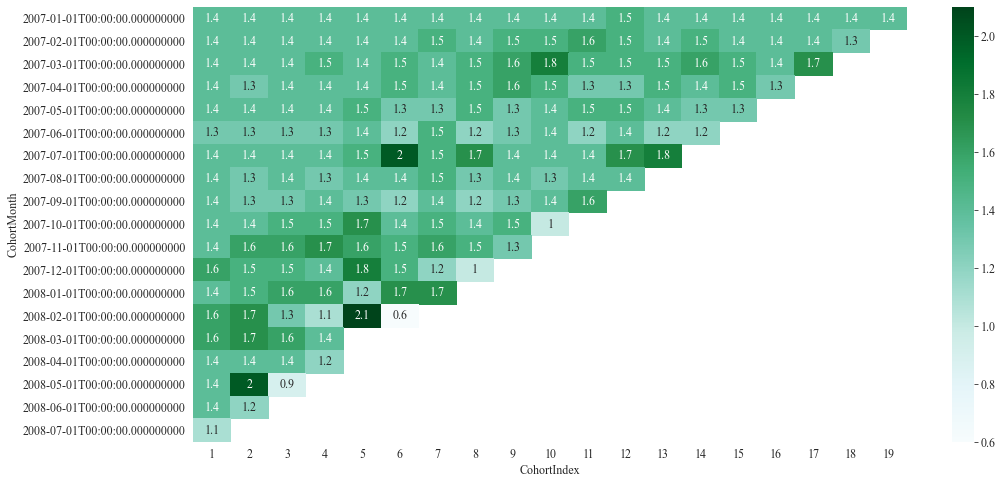

In [12]:
plt.figure(figsize=(16,8))
sns.heatmap(average_price.round(1), annot=True, cmap='BuGn')

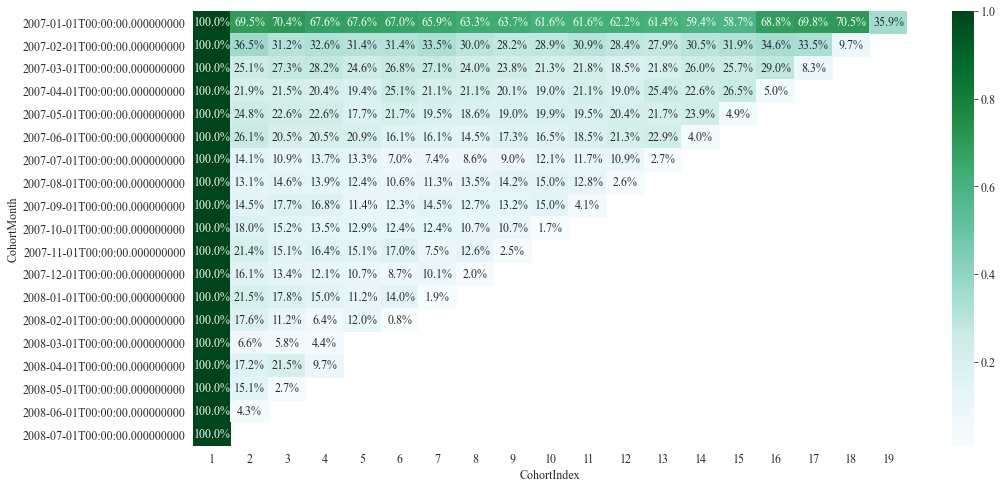

In [13]:
plt.figure(figsize=(16,8))
sns.heatmap(retention, annot=True, cmap='BuGn', fmt='.1%')

___
<h4>RFM Analysis (Recency, Frequency, & Monetary)</h4>

In [14]:
df['TotalSum'] = df['SPEND']

In [15]:
print(f"Min: {min(df['SHOP_DATE'])}\nMax: {max(df['SHOP_DATE'])}")

Min: 2007-01-01 00:00:00
Max: 2008-07-06 00:00:00


In [16]:
snapshot_date = max(df['SHOP_DATE']) + dt.timedelta(days=1)

datamart = df.groupby(by=['CUST_CODE']).agg({
    'SHOP_DATE': lambda i: (snapshot_date - i.max()).days,
    'BASKET_ID':'count',
    'TotalSum': 'sum'
})

datamart.rename(columns= {
    'SHOP_DATE':'Recency',
    'BASKET_ID':'Frequency',
    'TotalSum':'MonetaryValue'
}, inplace=True)

In [17]:
recency_labels = range(4,0,-1)
frequency_labels = range(1,5)
monetary_labels = range(1,5)
recency_quartiles = pd.qcut(datamart['Recency'], 4, labels=recency_labels)
frequency_quartiles = pd.qcut(datamart['Frequency'], 4, labels=frequency_labels)
monetary_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels=monetary_labels)

datamart = datamart.assign(R = recency_quartiles.values)
datamart = datamart.assign(F = frequency_quartiles.values)
datamart = datamart.assign(M = monetary_quartiles.values)

In [18]:
def join_rfm(i):
    return str(i['R']) + str(i['F']) + str(i['M'])

datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [19]:
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [20]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CUST_CODE,,,,,,,,
CUST0000000107,104,1,0.80,2,1,1,2.01.01.0,4
CUST0000000369,2,388,545.17,4,4,4,4.04.04.0,12
CUST0000001388,87,20,21.90,2,3,2,2.03.02.0,7
CUST0000002302,4,230,492.84,4,4,4,4.04.04.0,12
CUST0000002637,38,36,48.50,3,3,3,3.03.03.0,9
...,...,...,...,...,...,...,...,...
CUST0000999439,2,7,19.00,4,2,2,4.02.02.0,8
CUST0000999544,472,1,6.32,1,1,2,1.01.02.0,4
CUST0000999593,96,200,329.05,2,4,4,2.04.04.0,10


In [21]:
# Let's segment customers into THREE groups

def rfm_level(df):
    if (df['RFM_Score'] >= 10):
        return 'Top'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10):
        return 'Middle'
    else:
        return 'Low'

datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CUST_CODE,,,,,,,,,
CUST0000000107,104,1,0.80,2,1,1,2.01.01.0,4,Low
CUST0000000369,2,388,545.17,4,4,4,4.04.04.0,12,Top
CUST0000001388,87,20,21.90,2,3,2,2.03.02.0,7,Middle
CUST0000002302,4,230,492.84,4,4,4,4.04.04.0,12,Top
CUST0000002637,38,36,48.50,3,3,3,3.03.03.0,9,Middle


In [22]:
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           392.3       1.6           1.9   583
4           233.0       2.2           3.3   509
5           255.5       5.1           9.0   520
6           153.7       7.2          13.4   469
7           153.1      14.0          27.3   434
8            92.0      24.8          46.7   451
9            38.8      41.0          75.2   447
10           24.1      68.3         127.4   311
11           26.3     291.7         555.5   342
12            5.6     614.9        1133.4   825

___
<h4>Data Preprocessing for Segmentation</h4>

(0.0, 500.0)

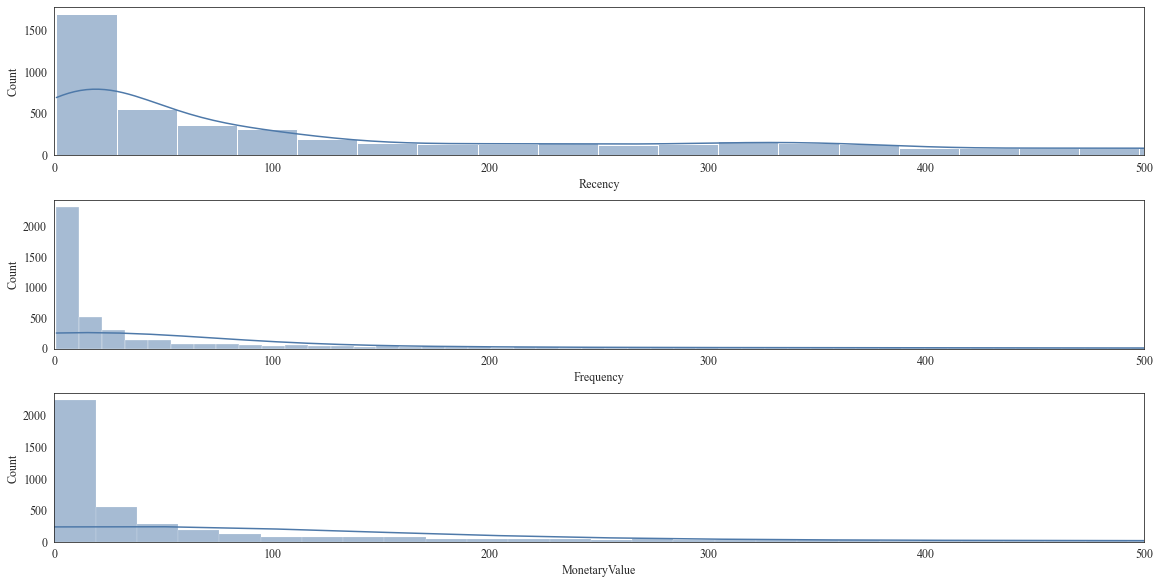

In [23]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
gs = GridSpec(3,1, figure=fig)
axes1 = fig.add_subplot(gs[0,0])
axes2 = fig.add_subplot(gs[1,0])
axes3 = fig.add_subplot(gs[2,0])

sns.histplot(datamart['Recency'], kde=True, ax=axes1)
sns.histplot(datamart['Frequency'], kde=True, ax=axes2)
sns.histplot(datamart['MonetaryValue'], kde=True, ax=axes3)

axes1.axes.set_xlim(0,500)
axes2.axes.set_xlim(0,500)
axes3.axes.set_xlim(0,500)

In [24]:
datamart_rfm = datamart[['Recency','Frequency','MonetaryValue']]
datamart_rfm_log = np.log(datamart_rfm)

In [25]:
scaler = StandardScaler()
scaler.fit(datamart_rfm_log)

datamart_normalized = scaler.transform(datamart_rfm_log)
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

(-5.0, 5.0)

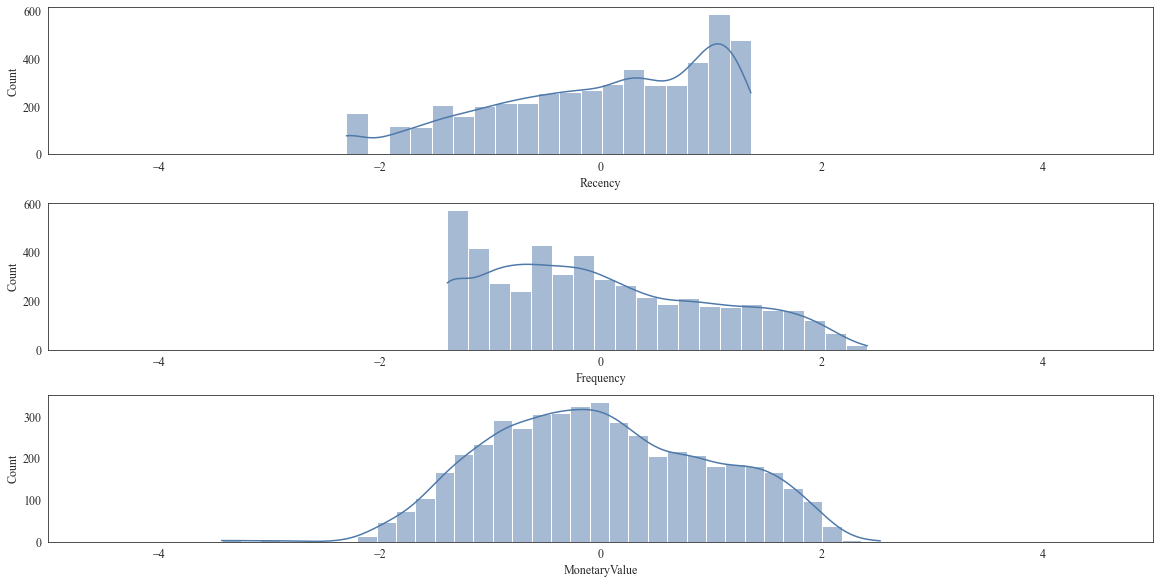

In [26]:
fig = plt.figure(figsize=(16,8),constrained_layout=True)
gs = GridSpec(3,1, figure=fig)
axes1 = fig.add_subplot(gs[0,0])
axes2 = fig.add_subplot(gs[1,0])
axes3 = fig.add_subplot(gs[2,0])

sns.histplot(datamart_normalized['Recency'], kde=True, ax=axes1)
sns.histplot(datamart_normalized['Frequency'], kde=True, ax=axes2)
sns.histplot(datamart_normalized['MonetaryValue'], kde=True, ax=axes3)

axes1.axes.set_xlim(-5,5)
axes2.axes.set_xlim(-5,5)
axes3.axes.set_xlim(-5,5)

___
<h4>Clustering using KMeans (RFM Segmentation)</h4>

In [27]:
wcss = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=26)
    kmeans.fit(datamart_normalized)
    wcss[k] = kmeans.inertia_

Text(0, 0.5, 'WCSS')

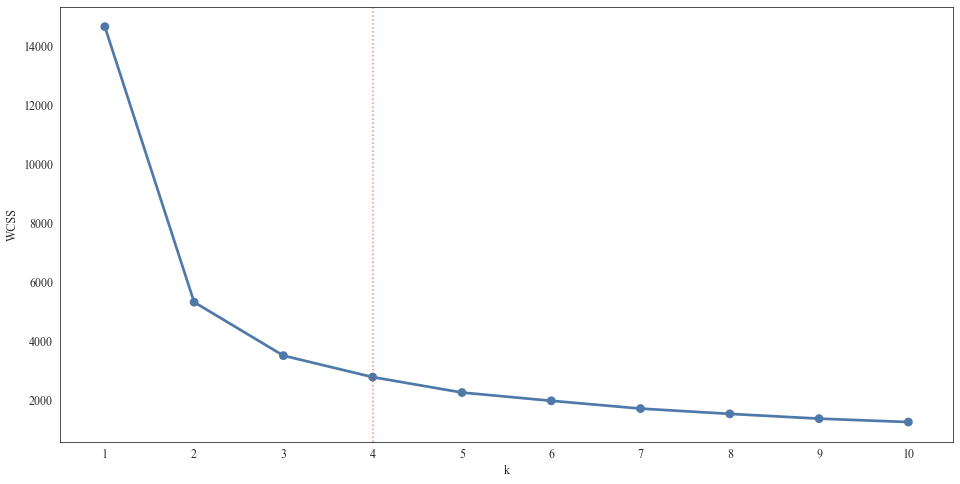

In [28]:
plt.figure(figsize=(16,8))
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.axvline(3, color='red', alpha=0.5, linestyle=':')
plt.xlabel('k')
plt.ylabel('WCSS')

# After the visualization, the potential k could be 4 or 5

In [29]:
kmeans = KMeans(n_clusters=4, random_state=26)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

datamart_rfm_kmean = datamart_rfm.assign(Cluster=cluster_labels)
grouped = datamart_rfm_kmean.groupby(by=['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count']
}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          8.87    584.87       1083.63   999
1        275.63      2.11          2.93  1419
2        196.40     13.67         26.23  1340
3         31.44     58.53        108.62  1133

In [30]:
datamart_normalized = pd.DataFrame(datamart_normalized,
                                  index=datamart_rfm.index,
                                  columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_kmean['Cluster']

In [31]:
datamart_normalized

,Recency,Frequency,MonetaryValue,Cluster
CUST_CODE,,,,
CUST0000000107,0.390941,-1.388412,-1.541904,1
CUST0000000369,-1.899140,1.456735,1.270390,0
CUST0000001388,0.287495,0.041430,-0.115278,2
CUST0000002302,-1.497402,1.207146,1.226891,0
CUST0000002637,-0.192588,0.321977,0.227443,3
...,...,...,...,...
CUST0000999439,-1.899140,-0.459642,-0.176508,3
CUST0000999544,1.267614,-1.388412,-0.650976,1
CUST0000999593,0.344550,1.140438,1.052757,3


___
<h4>Snake Plot</h4>

In [32]:
datamart_melt = pd.melt(datamart_normalized.reset_index(),
                       id_vars=['CUST_CODE', 'Cluster'],
                       value_vars=['Recency','Frequency','MonetaryValue'],
                       var_name='Attribute',
                       value_name='Value')

Text(0.5, 0.98, 'Snake Plot of each Cluster')

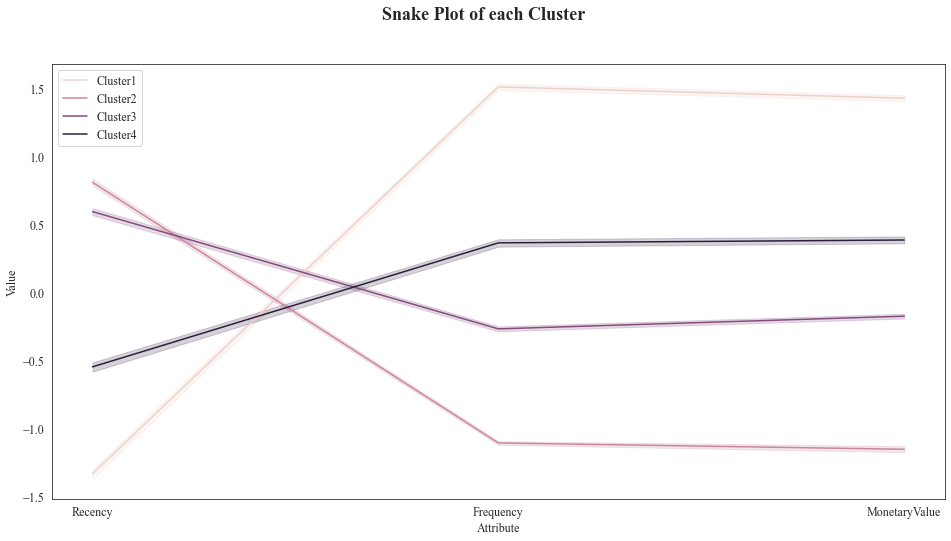

In [33]:
plt.figure(figsize=(16,8))
sns.lineplot(data=datamart_melt, x='Attribute', y='Value', hue='Cluster')
plt.legend(['Cluster1','Cluster2','Cluster3','Cluster4'], loc='upper left')
plt.suptitle('Snake Plot of each Cluster')

<center><h1>END</h1></center>

<center>Thank you!</center>